<a href="https://colab.research.google.com/github/werlang/emolearn-ml-model/blob/main/personalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence, plot_model, to_categorical
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import TimeDistributed, GRU, LSTM, Dropout, Conv1D, Conv2D, Conv3D, ConvLSTM2D, BatchNormalization, MaxPooling1D, MaxPooling2D, MaxPooling3D, GlobalAveragePooling2D, Flatten, Dense, Input, Add, Activation, AveragePooling3D, AveragePooling2D, ZeroPadding3D, Bidirectional, Concatenate
from tensorflow.keras.optimizers import Adam, SGD, Nadam
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
import os, cv2
import datetime
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import math
from IPython.display import Image, display
from numba import cuda
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
import functools

# from imblearn.over_sampling import SMOTE
# sm = SMOTE(sampling_strategy=0.6666)
# X, y = sm.fit_resample(X, y)


drive_save_path = 'drive/My Drive/1NOSYNC/DT/checkpoint'
ident_name = 'personality'
dir_name = '2021-12-9-2-44-8-personality'
batch_size = 50
time_frames = 20
interval = 2
stride = 1
fold_step = 1
n_folds = 10

epoch = 0


def restart():
    cuda.select_device(0)
    cuda.close()


def start_colab():
    from google.colab import drive
    drive._mount('/content/drive', force_remount=True)
    !pip install Keras-Applications
    # !pip install git+https://github.com/rcmalli/keras-vggface.git
    !pip install keras-tcn


def extract_data():
    !mkdir p2m
    !mkdir p2m/features

    # aligned faces extracted from openface
    print("COPYING ALIGNED FACES...")
    !unzip -n -q "drive/My Drive/1NOSYNC/DT/p2m_dataset/224/p2m_faces.zip" -d p2m/features
    print("COPYING OPENFACE FEATURES...")
    !unzip -n -q "drive/My Drive/1NOSYNC/DT/p2m_dataset/224/p2m_openface.zip" -d p2m/features
    print("COPYING LABELS...")
    !cp -r "drive/My Drive/1NOSYNC/DT/p2m_dataset/224/labels.csv" p2m
    !cp -r "drive/My Drive/1NOSYNC/DT/p2m_dataset/224/personalities.csv" p2m

    print("P2M DONE")


def create_folds_p2m():
    num_classes = 2
    label_window = time_frames
    print("CREATING FOLDS...")
    subs = {}

    csv = pd.read_csv('p2m/labels.csv')
    Y = np.array(csv.iloc[:,3])
    subjects = np.array(csv['SUBJECT'])
    clips = np.array(csv['CLIP'])
    source_frames = np.array(csv['SOURCE_FRAMES'])

    Y = to_categorical(Y, num_classes)    

    for i in range(len(subjects)):
        if not subjects[i] in subs:
            subs[subjects[i]] = [0 for x in range(num_classes)]
        subs[subjects[i]] = np.add(subs[subjects[i]], Y[i])

    # total = np.sum(Y, axis=0)
    # print(total, total / len(Y))
    # print(subs)

    folds = []
    fold_names = []
    for i in subs:
        if len(folds) < n_folds + 1:
            folds.append(subs[i])
            fold_names.append([i])
        else:
            summed = np.sum(folds, axis=1)
            index = list(summed).index(min(summed))
            folds[index] = np.add(folds[index], subs[i])
            fold_names[index].append(i)

    # print(folds)
    # print(fold_names)
    # print(np.sum(folds, axis=1))

    # print("GETTING FOLDS DATA...")
    # build frames array
    videos, labels, opface, xlabel, pers = [], [], [], [], []
    for i in range(len(fold_names)):
        videos.append([])
        opface.append([])
        labels.append([])
        xlabel.append([])
        pers.append([])

    fps = 30
    skip = int(round(interval * fps / time_frames, 0))

    # pick personalities csv and scale
    personality_csv = pd.read_csv('p2m/personalities.csv')
    personality_csv = np.array(personality_csv)[:,1:]
    min_max_scaler = MinMaxScaler()
    personality_csv = min_max_scaler.fit_transform(personality_csv)

    for Yi in range(len(Y)):
        print("\rCLIP {}/{}".format(Yi, len(Y)), end="")
        clip = clips[Yi]
        start_frame = source_frames[Yi].split("-")[0]
        subject = subjects[Yi]
        subject_personality = personality_csv[int(subject)]

        for f in range(n_folds + 1):
            if int(subject) in fold_names[f]:
                files, filesof = [], []
                
                of_path = "p2m/features/{:02}.csv".format(subject)

                for i in range(60):
                    image_path = "p2m/features/faces/{:02}.{:03}.{:02}.jpg".format(subject, clip, i)
                    
                    if os.path.isfile(image_path) and os.path.isfile(of_path):
                        files.append(image_path)
                        filesof.append("{}|{}".format(of_path, int(start_frame) + i))

                # append only the parts relative to the video section
                last = (len(files) - time_frames*skip) // skip
                rg = range(0, last + 1, np.max([1, int(stride * time_frames)]))
                for i in rg:
                    temp, tpof = [], []
                    for j in range(i*skip, (i+time_frames)*skip, skip):
                        temp.append(files[j])
                        tpof.append(filesof[j])
                    videos[f].append(temp)
                    opface[f].append(tpof)
                    labels[f].append(Y[Yi])

                    # get previous clip labels from same subject
                    xl = []
                    for l in range(Yi - 1, 0, -1):
                        sub2 = subjects[l]
                        if subject == sub2:
                            xl.append(Y[l])
                        if len(xl) == label_window:
                            break
                        
                    xl = [(xl[0] if len(xl) > 0 else np.array([0., 1.])) for x in range(label_window - len(xl))] + xl
                    xlabel[f].append(xl)

                    xp = np.array([subject_personality for x in range(label_window)])
                    pers[f].append(xp)


    print("\nDONE")
    return videos, opface, xlabel, pers, labels


def save_folds(folds):
    !mkdir folds

    first_only = True

    folds_copy = folds.copy()

    if len(folds) == 1:
        test_X = folds_copy[0][0].pop(0)
        test_XO = folds_copy[0][1].pop(0)
        test_XL = folds_copy[0][2].pop(0)
        test_XP = folds_copy[0][3].pop(0)
        test_Y = folds_copy[0][4].pop(0)

        videos = folds_copy[0][0]
        opface = folds_copy[0][1]
        xlabel = folds_copy[0][2]
        person = folds_copy[0][3]
        labels = folds_copy[0][4]

    test_Y = np.array(test_Y)
    print(test_Y.shape)
    np.save("folds/test_Y.npy", test_Y)
    
    test_X = np.array(test_X)
    print(test_X.shape)
    np.save("folds/test_XV.npy", test_X)

    test_XO = np.array(test_XO)
    print(test_XO.shape)
    np.save("folds/test_XO.npy", test_XO)

    test_XL = np.array(test_XL)
    print(test_XL.shape)
    np.save("folds/test_XL.npy", test_XL)

    test_XP = np.array(test_XP)
    print(test_XP.shape)
    np.save("folds/test_XP.npy", test_XP)

    for i in range(n_folds):
        print("SAVING FOLD {}...".format(i+1))
        train_X = videos.copy()
        train_XO = opface.copy()
        train_XL = xlabel.copy()
        train_XP = person.copy()
        train_Y = labels.copy()

        val_X = train_X.pop(i)
        val_XO = train_XO.pop(i)
        val_XL = train_XL.pop(i)
        val_XP = train_XP.pop(i)
        val_Y = train_Y.pop(i)

        train_X = np.concatenate(train_X)
        train_XO = np.concatenate(train_XO)
        train_XL = np.concatenate(train_XL)
        train_XP = np.concatenate(train_XP)
        train_Y = np.concatenate(train_Y)

        # create index array for resample
        I = np.array([x for x in range(len(train_X))]).reshape(-1,1)

        # I, train_Y = ros.fit_resample(I, train_Y)
        # I, train_Y = rus.fit_resample(I, train_Y)
        # train_Y = to_categorical(train_Y, len(original))

        # copy resampled elements from original arrays according to resampling indexes
        ntx, ntxo, ntxl, ntxp = [], [], [], []
        for x in I:
            ntx.append(train_X[x[0]])
            ntxo.append(train_XO[x[0]])
            ntxl.append(train_XL[x[0]])
            ntxp.append(train_XP[x[0]])
        train_X = ntx
        train_XO = ntxo
        train_XL = ntxl
        train_XP = ntxp

        # save folds to file
        train_Y = np.array(train_Y)
        print(train_Y.shape)
        np.save("folds/fold_{}_train_Y.npy".format(i), train_Y)
        
        train_X = np.array(train_X)
        print(train_X.shape)
        np.save("folds/fold_{}_train_XV.npy".format(i), train_X)

        train_XO = np.array(train_XO)
        print(train_XO.shape)
        np.save("folds/fold_{}_train_XO.npy".format(i), train_XO)

        train_XL = np.array(train_XL)
        print(train_XL.shape)
        np.save("folds/fold_{}_train_XL.npy".format(i), train_XL)
        
        train_XP = np.array(train_XP)
        print(train_XP.shape)
        np.save("folds/fold_{}_train_XP.npy".format(i), train_XP)

        val_Y = np.array(val_Y)
        print(val_Y.shape)
        np.save("folds/fold_{}_validation_Y.npy".format(i), val_Y)
        
        val_X = np.array(val_X)
        print(val_X.shape)
        np.save("folds/fold_{}_validation_XV.npy".format(i), val_X)

        val_XO = np.array(val_XO)
        print(val_XO.shape)
        np.save("folds/fold_{}_validation_XO.npy".format(i), val_XO)

        val_XL = np.array(val_XL)
        print(val_XL.shape)
        np.save("folds/fold_{}_validation_XL.npy".format(i), val_XL)

        val_XP = np.array(val_XP)
        print(val_XP.shape)
        np.save("folds/fold_{}_validation_XP.npy".format(i), val_XP)

        if first_only:
            break


class Generator_V(Sequence):
    def __init__(self, gen_split, batch_size, frames):
        print("BUILDING GENERATOR...")
        self.batch_size = batch_size 
        self.labels, self.videos, = [], []
        self.loadedOF = {}

        file_prefix = "" if gen_split == "Test" else "fold_{}_".format(fold_step-1)
        self.videos = np.load("folds/{}{}_XV.npy".format(file_prefix, gen_split.lower()))
        self.opface = np.load("folds/{}{}_XO.npy".format(file_prefix, gen_split.lower()))
        self.xlabel = np.load("folds/{}{}_XL.npy".format(file_prefix, gen_split.lower()))
        self.person = np.load("folds/{}{}_XP.npy".format(file_prefix, gen_split.lower()))
        self.labels = np.load("folds/{}{}_Y.npy".format(file_prefix, gen_split.lower()))

        # self.videos, self.labels = shuffle(self.videos, self.labels, random_state=0)
        print("Done")


    def __len__(self):
        return int(np.ceil(len(self.videos) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_xv = self.videos[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_xo = self.opface[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_xl = self.xlabel[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_xp = self.person[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]

        videos, opface = [], []
        for video in batch_xv:
            images = []
            for name in video:
                img = cv2.imread(name)
                img = cv2.resize(img, (224, 224))
                images.append(img/255)
            videos.append(np.array(images))

        for video in batch_xo:
            images = []

            of_path = video[0].split("|")[0]
            if not of_path in self.loadedOF:
                csv_of = pd.read_csv(of_path)
                rows = csv_of[[' gaze_0_x',' gaze_0_y',' gaze_0_z',' gaze_1_x',' gaze_1_y',' gaze_1_z',' gaze_angle_x',' gaze_angle_y',' pose_Tx',' pose_Ty',' pose_Tz',' pose_Rx',' pose_Ry',' pose_Rz',' AU01_r',' AU02_r',' AU04_r',' AU05_r',' AU06_r',' AU07_r',' AU09_r',' AU10_r',' AU12_r',' AU14_r',' AU15_r',' AU17_r',' AU20_r',' AU23_r',' AU25_r',' AU26_r',' AU45_r',' AU01_c',' AU02_c',' AU04_c',' AU05_c',' AU06_c',' AU07_c',' AU09_c',' AU10_c',' AU12_c',' AU14_c',' AU15_c',' AU17_c',' AU20_c',' AU23_c',' AU25_c',' AU26_c',' AU28_c',' AU45_c']]
                min_max_scaler = MinMaxScaler()
                self.loadedOF[of_path] = min_max_scaler.fit_transform(rows)

            rows = self.loadedOF[of_path]

            for name in video:
                i = int(name.split("|")[1])
                try:
                    img = rows[i]
                except:
                    print("ERROR", i, len(rows))
                images.append(img)

            opface.append(np.array(images))

        videos = np.array(videos)
        opface = np.array(opface)
        xlabel = np.array(batch_xl)
        person = np.array(batch_xp)
        label = np.array(batch_y)

        # return [videos, opface, xlabel, person], label
        # return [videos, opface, xlabel], label
        return [videos, opface], label


def build_model(epoch=0, print_model=False):
    from tcn import TCN, tcn_full_summary

    img_size = 224
    of_features = 49

    def model_convlstm(input):
        filters = 256

        x = ConvLSTM2D(filters, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(5e-4), recurrent_regularizer=l2(1e-6), return_sequences=True)(input)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = ConvLSTM2D(filters, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(5e-4), recurrent_regularizer=l2(1e-6), return_sequences=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = MaxPooling2D(pool_size=3, strides=2, padding='valid')(x)
        x = Flatten()(x)

        return x

    def model_tcn(input):
        filters = 512

        x = TCN(filters)(input)
        
        return x

    def model_inception(input):
        inception = tf.keras.applications.InceptionResNetV2(
            input_shape = (img_size, img_size, 3),
            weights = 'imagenet',
            include_top = False
        )

        for layer in inception.layers:
            layer.trainable = False

        x = TimeDistributed(inception)(input)

        return x

    print("Building model...")
    ########### IF BUILT, MUST DEFINE A NAME TO APPEND TO DIRECTORY NAME ###############
    global ident_name

    ########### IF LOADED, MUST DEFINE DIR NAME AND STARTING EPOCH ############
    global dir_name

    if not epoch:
        input_v = Input(shape=(time_frames, img_size, img_size, 3))
        input_o = Input(shape=(time_frames, of_features))
        # input_l = Input(shape=(time_frames, 2))
        # input_p = Input(shape=(time_frames, 5))

        mv = model_inception(input_v)
        mv = model_convlstm(mv)
        mo = model_tcn(input_o)
        # ml = model_tcn(input_l)
        # mp = model_tcn(input_p)

        # joint model
        x = Concatenate()([mv, mo])
        # x = Concatenate()([mv, mo, ml])
        # x = Concatenate()([mv, mo, ml, mp])
        
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.8)(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.8)(x)
        x = Dense(2, activation='softmax')(x)

        model = Model([input_v, input_o], x)
        # model = Model([input_v, input_o, input_l], x)
        # model = Model([input_v, input_o, input_l, input_p], x)

        model.compile(
            loss='categorical_crossentropy',
            optimizer = SGD(learning_rate=0.0001, momentum=0.9), 
            metrics=['accuracy'])
    
        t = datetime.datetime.now()
        prefix = str(t.year) +'-'+ str(t.month) +'-'+ str(t.day) +'-'+ str(t.hour) +'-'+ str(t.minute) +'-'+ str(t.second)
        save_dir = "{}/{}-{}".format(drive_save_path, prefix, ident_name)
        os.mkdir(save_dir)
    else:
        file_name = "{:03d}.h5".format(epoch)
        save_dir = "{}/{}".format(drive_save_path, dir_name)
        print("Loading model from {}/{}.".format(save_dir, file_name))
        model = load_model("{}/{}".format(save_dir, file_name), custom_objects={'TCN': TCN})

    if print_model:
        plot_model(model, show_layer_names=False, show_shapes=True, expand_nested=True)
        # display(Image('model.png'))

    return model, save_dir, epoch


def set_callbacks():
    #callbacks
    checkpoint = ModelCheckpoint(
        filepath = save_dir + '/{epoch:03d}.h5', 
        monitor = 'val_loss', 
        verbose=1, 
        save_best_only=True,
    )

    tensorboard = TensorBoard(
    	log_dir         = "{}/logs".format(save_dir),
    	histogram_freq  = 0,
    	write_graph     = True,
    	write_grads     = False,
    	write_images    = True
    )

    early_stop = EarlyStopping(
        monitor 	= 'val_loss',
        patience 	= 20,
        restore_best_weights = True,
        verbose     = 1,
        min_delta   = 1e-5
    )

    reduce_lr_plateau = ReduceLROnPlateau(
        monitor 	= 'val_loss',
        factor		= 0.5,
        patience	= 10,
        min_lr		= 1e-6,
        verbose     = 1
    )

    # return [checkpoint, tensorboard]
    return [checkpoint, early_stop, reduce_lr_plateau, tensorboard]


def fit_model(train_weights, epoch=0):
    #calculate weights based on train set distribution
    num_classes = len(train_weights)
    if train_weights == [1 for x in range(num_classes)]:
        weights = {x:1 for x in range(num_classes)}
    else:
        weights = {x: train_weights[x] for x in range(len(train_weights))}
        print("Train weights: {}".format(weights))

    def run():
        #run the model
        return model.fit(
            gen_train,
            epochs = 1000,
            validation_data = gen_val,
            class_weight = weights,
            callbacks = callbacks,
            initial_epoch = epoch)
        
    hist = run()  

    plot_hist(hist)

    return hist


def plot_hist(hist):
    plt.plot(hist.history['loss'], '#0000ff', label="loss")
    plt.plot(hist.history['val_loss'], '#ff0000', label="val_loss")
    plt.legend()
    plt.show()

    plt.plot(hist.history['accuracy'], '#0000ff', label="acc")
    plt.plot(hist.history['val_accuracy'], '#ff0000', label="val_acc")
    # plt.plot(hist.history['accuracy'], '#0055aa', label="acc")
    # plt.plot(hist.history['val_accuracy'], '#aa5500', label="val_acc")
    plt.legend()
    plt.show()


def predict(**kw):
    global gen_test

    Y_true = np.load("folds/test_Y.npy")
    num_classes = Y_true.shape[1]
    Y_true = Y_true.argmax(axis=1)

    print("Predicting...")
    Y_pred = model.predict(gen_test, verbose=1).argmax(axis=1)
    print("\nConfusion matrix:")
    cm = confusion_matrix(Y_true, Y_pred)
    print(cm)

    print("\nEvaluating...")
    ev = model.evaluate(gen_test, verbose=1)
    # print("Loss: {}, Acc: {}".format(ev[0], ev[1]))

    hits = [0 for x in range(num_classes)]
    total = [0 for x in range(num_classes)]
    for i in range(len(Y_true)):
        for c in range(num_classes):
            if (Y_true[i] == c and Y_pred[i] == c):
                hits[c] = hits[c] + 1
            if Y_true[i] == c:
                total[c] = total[c] + 1

    print("\nPer class accuracy:")
    for c in range(num_classes):
        hits[c] = hits[c] / total[c]
        print("{}: {}".format(c, hits[c]))

    print("Average class accuracy: {}".format(sum(hits) / len(hits)))

    f1 = f1_score(Y_true, Y_pred, average=None)
    print("F1 score: {}. Avg F1: {}".format(f1, np.mean(f1)))

    return gen_test
        

BUILDING GENERATOR...
Done
BUILDING GENERATOR...
Done
BUILDING GENERATOR...
Done
Building model...
Train weights: {0: 2.5943563, 1: 1.6272124}
Epoch 1/1000
59/59 [==============================] - ETA: 0s - loss: 8.4959 - accuracy: 0.5078
Epoch 00001: val_loss improved from inf to 1.52450, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-12-8-20-41-45-personality/001.h5
59/59 [==============================] - 173s 2s/step - loss: 8.4959 - accuracy: 0.5078 - val_loss: 1.5245 - val_accuracy: 0.4536 - lr: 1.0000e-04
Epoch 2/1000
59/59 [==============================] - ETA: 0s - loss: 2.2187 - accuracy: 0.5143
Epoch 00002: val_loss improved from 1.52450 to 1.50685, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-12-8-20-41-45-personality/002.h5
59/59 [==============================] - 121s 2s/step - loss: 2.2187 - accuracy: 0.5143 - val_loss: 1.5069 - val_accuracy: 0.6151 - lr: 1.0000e-04
Epoch 3/1000
59/59 [==============================] - ETA: 0s - loss: 2.1841 - ac

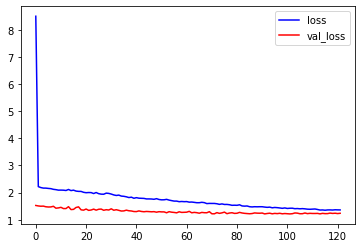

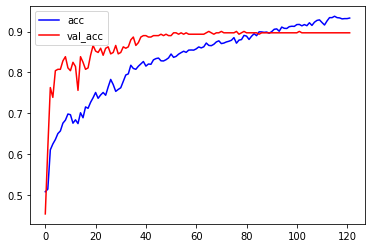

Predicting...
7/7 [==============================] - 24s 2s/step

Confusion matrix:
[[206  17]
 [ 15  88]]

Evaluating...
7/7 [==============================] - 12s 1s/step - loss: 1.1425 - accuracy: 0.9018

Per class accuracy:
0: 0.9237668161434978
1: 0.8543689320388349
Average class accuracy: 0.8890678740911664
F1 score: [0.92792793 0.84615385]. Avg F1: 0.887040887040887


In [ ]:
# restart()
# start_colab()
# extract_data()
# fold_p2m = create_folds_p2m()
# save_folds([fold_p2m])

gen_train = Generator_V('Train', batch_size, time_frames)
gen_val = Generator_V('Validation', batch_size, time_frames)
gen_test = Generator_V('Test', batch_size, time_frames)

model, save_dir, epoch = build_model(epoch, print_model=False)

callbacks = set_callbacks()
fit_model(list(len(gen_train.labels) / np.sum(gen_train.labels, axis=0)), epoch)
gen_test = predict()

# model.summary()

In [ ]:
# restart()
# start_colab()
# extract_data()
# fold_p2m = create_folds_p2m()
# save_folds([fold_p2m])

gen_train = Generator_V('Train', batch_size, time_frames)
gen_val = Generator_V('Validation', batch_size, time_frames)
gen_test = Generator_V('Test', batch_size, time_frames)

model, save_dir, epoch = build_model(epoch, print_model=False)

callbacks = set_callbacks()
fit_model(list(len(gen_train.labels) / np.sum(gen_train.labels, axis=0)), epoch)
gen_test = predict()

# model.summary()

BUILDING GENERATOR...
Done
BUILDING GENERATOR...
Done
BUILDING GENERATOR...
Done
Building model...
Train weights: {0: 2.5943563, 1: 1.6272124}
Epoch 1/1000
59/59 [==============================] - ETA: 0s - loss: 6.9255 - accuracy: 0.5364
Epoch 00001: val_loss improved from inf to 1.36262, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-12-9-2-44-8-personality/001.h5
59/59 [==============================] - 160s 2s/step - loss: 6.9255 - accuracy: 0.5364 - val_loss: 1.3626 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 2/1000
59/59 [==============================] - ETA: 0s - loss: 2.2724 - accuracy: 0.5700
Epoch 00002: val_loss did not improve from 1.36262
59/59 [==============================] - 117s 2s/step - loss: 2.2724 - accuracy: 0.5700 - val_loss: 1.4666 - val_accuracy: 0.7457 - lr: 1.0000e-04
Epoch 3/1000
59/59 [==============================] - ETA: 0s - loss: 2.1439 - accuracy: 0.6169
Epoch 00003: val_loss did not improve from 1.36262
59/59 [=========================

Building model...
Loading model from drive/My Drive/1NOSYNC/DT/checkpoint/2021-12-9-2-44-8-personality/089.h5.
Train weights: {0: 2.5943563, 1: 1.6272124}
Epoch 90/1000
59/59 [==============================] - ETA: 0s - loss: 1.3448 - accuracy: 0.9184
Epoch 00090: val_loss improved from inf to 1.20133, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-12-9-2-44-8-personality/090.h5
59/59 [==============================] - 162s 2s/step - loss: 1.3448 - accuracy: 0.9184 - val_loss: 1.2013 - val_accuracy: 0.8832 - lr: 2.5000e-05
Epoch 91/1000
59/59 [==============================] - ETA: 0s - loss: 1.3202 - accuracy: 0.9211
Epoch 00091: val_loss improved from 1.20133 to 1.17368, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-12-9-2-44-8-personality/091.h5
59/59 [==============================] - 118s 2s/step - loss: 1.3202 - accuracy: 0.9211 - val_loss: 1.1737 - val_accuracy: 0.8900 - lr: 2.5000e-05
Epoch 92/1000
59/59 [==============================] - ETA: 0s - loss: 

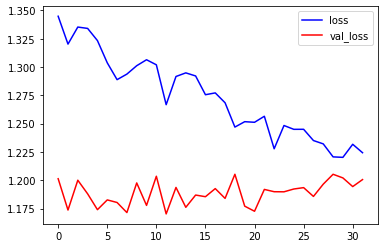

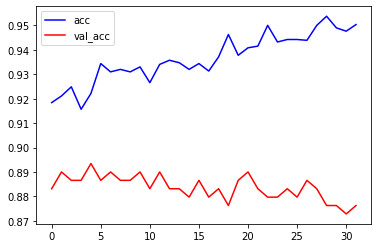

Predicting...
7/7 [==============================] - 20s 2s/step

Confusion matrix:
[[202  21]
 [ 15  88]]

Evaluating...
7/7 [==============================] - 11s 1s/step - loss: 1.1733 - accuracy: 0.8896

Per class accuracy:
0: 0.905829596412556
1: 0.8543689320388349
Average class accuracy: 0.8800992642256955
F1 score: [0.91818182 0.83018868]. Avg F1: 0.8741852487135505


In [ ]:
# restart()
# start_colab()
# extract_data()
# fold_p2m = create_folds_p2m()
# save_folds([fold_p2m])

# gen_train = Generator_V('Train', batch_size, time_frames)
# gen_val = Generator_V('Validation', batch_size, time_frames)
# gen_test = Generator_V('Test', batch_size, time_frames)

model, save_dir, epoch = build_model(epoch, print_model=False)

callbacks = set_callbacks()
fit_model(list(len(gen_train.labels) / np.sum(gen_train.labels, axis=0)), epoch)
gen_test = predict()

# model.summary()

BUILDING GENERATOR...
Done
BUILDING GENERATOR...
Done
BUILDING GENERATOR...
Done
Building model...
219070464/219055592 [==============================] - 7s 0us/step
Train weights: {0: 2.5943563, 1: 1.6272124}
Epoch 1/1000
59/59 [==============================] - ETA: 0s - loss: 5.8555 - accuracy: 0.4932
Epoch 00001: val_loss improved from inf to 1.60428, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-12-9-7-7-32-personality/001.h5
59/59 [==============================] - 146s 2s/step - loss: 5.8555 - accuracy: 0.4932 - val_loss: 1.6043 - val_accuracy: 0.2474 - lr: 1.0000e-04
Epoch 2/1000
59/59 [==============================] - ETA: 0s - loss: 2.3727 - accuracy: 0.5007
Epoch 00002: val_loss improved from 1.60428 to 1.51799, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-12-9-7-7-32-personality/002.h5
59/59 [==============================] - 117s 2s/step - loss: 2.3727 - accuracy: 0.5007 - val_loss: 1.5180 - val_accuracy: 0.4536 - lr: 1.0000e-04
Epoch 3/1000
59/59

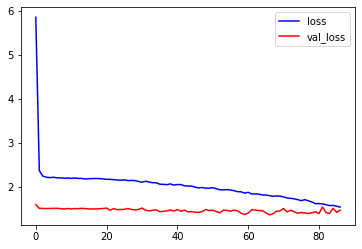

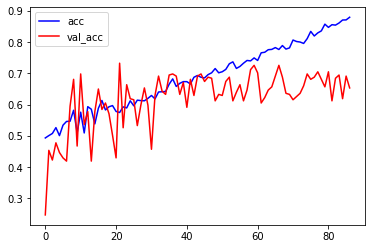

Predicting...
7/7 [==============================] - 18s 2s/step

Confusion matrix:
[[ 78 145]
 [ 34  69]]

Evaluating...
7/7 [==============================] - 11s 1s/step - loss: 1.5611 - accuracy: 0.4509

Per class accuracy:
0: 0.34977578475336324
1: 0.6699029126213593
Average class accuracy: 0.5098393486873612
F1 score: [0.46567164 0.43533123]. Avg F1: 0.4505014360374782


In [ ]:
# restart()
# start_colab()
# extract_data()
# fold_p2m = create_folds_p2m()
# save_folds([fold_p2m])

gen_train = Generator_V('Train', batch_size, time_frames)
gen_val = Generator_V('Validation', batch_size, time_frames)
gen_test = Generator_V('Test', batch_size, time_frames)

model, save_dir, epoch = build_model(epoch, print_model=False)

callbacks = set_callbacks()
fit_model(list(len(gen_train.labels) / np.sum(gen_train.labels, axis=0)), epoch)
gen_test = predict()

# model.summary()